# 以Toy model演示MAML 演算法
就同老師所言，Model Agnostic Meta Learning這個方案套用每個task的更新方向來更新meta model，以獲得一個好的初始值。


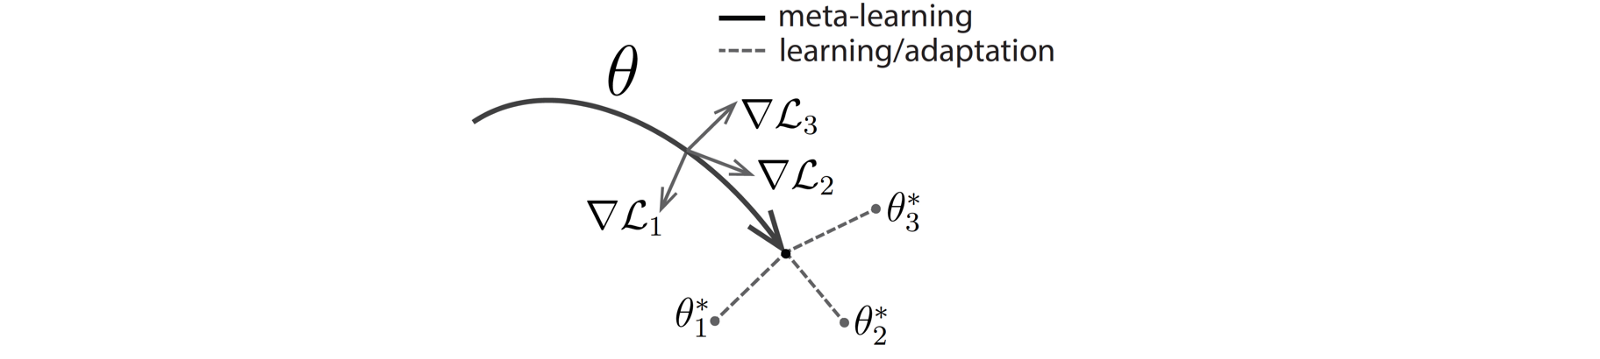

### Imports

In [1]:
import os
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as keras_backend
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Other dependencies
import random
import sys
import time

import numpy as np
import matplotlib.pyplot as plt
# mute warnings
import tensorflow.python.util.deprecation as deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

# Reproduction
np.random.seed(333)

print('Python version: ', sys.version)
print('TensorFlow version: ', tf.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('GPU found at: {}'.format(device_name))

Python version:  3.6.10 |Anaconda, Inc.| (default, May  7 2020, 19:46:08) [MSC v.1916 64 bit (AMD64)]
TensorFlow version:  2.3.1
GPU found at: /device:GPU:0


In [2]:
TRAIN_SIZE = 10000
EPOCHS = 1

## Dataset
* 以random sample x值預測整個Sine wave長像，output為一維向量
* y=a*sin(x-$\theta$)
* 震幅(amplitude) a: 0.1~5.0
* 相位(phase) $\theta$: 0~$\pi$
* x值範圍: -5~5

我們用一個class來定義data loader:
1. \__init__: 參數設定
2. batch: sample一個batch的資料，裡面有K個資料點(n-way-k-shot的K，regression沒有n-way)

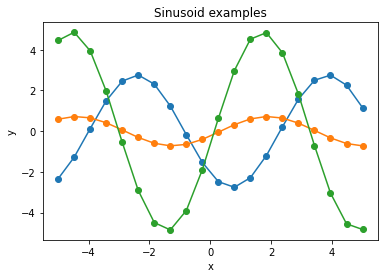

In [3]:
'''
一個class生出一種sin wave的generator，可以亂數地從這個wave中取資料點
K: samples per sine wave
'''
class SinusoidGenerator():
    def __init__(self, K=10, amplitude=None, phase=None):
        self.K = K
        self.amplitude = np.float32(amplitude if amplitude else np.random.uniform(0.1, 5.0))
        self.phase = np.float32(phase if amplitude else np.random.uniform(0, np.pi))
        self.x = np.float32(np.random.uniform(-5, 5, self.K))
        
    def f(self, x):
        '''Sinewave function.'''
        return self.amplitude * np.sin(x - self.phase)

    def batch(self,  x = None):
        '''Returns a batch of size K.'''
        x = self.x if x is None else x
        y = self.f(x)
        return x[:, None], y[:, None]
    
    def equally_spaced_samples(self, K=None):
        '''Returns `K` equally spaced samples.'''
        if K is None:
            K = self.K
        return self.batch(x=np.linspace(-5, 5, K,dtype=np.float32))

for _ in range(3):
    plt.title('Sinusoid examples')
    x,y=SinusoidGenerator(K=20).equally_spaced_samples()
    plt.plot(x,y, marker='o')
    plt.xlabel('x')
    plt.ylabel('y')
plt.show()

### Generate sinusoid datasets
source datasets有10000個set
target dataset 有10個set

In [5]:
def generate_dataset(K, train_size=10000, test_size=10):
    '''Generate train and test dataset.'''
    def _generate_dataset(size):
        return [SinusoidGenerator(K=K) for _ in range(size)]
    return _generate_dataset(train_size), _generate_dataset(test_size) 

train_ds, test_ds = generate_dataset(K=10, train_size=TRAIN_SIZE)

# 組建模型
用簡單的兩層dense層加上outputlayer做輸出

In [6]:
class SineModel(keras.Model):
    def __init__(self):
        super().__init__()
        self.hidden1 = keras.layers.Dense(40, input_shape=(1,))
        self.hidden2 = keras.layers.Dense(40)
        self.out = keras.layers.Dense(1)
        
    def forward(self, x):
        x = keras.activations.relu(self.hidden1(x))
        x = keras.activations.relu(self.hidden2(x))
        x = self.out(x)
        return x

一個接著一個task訓練(連續 task 的model pre-training)當作baseline

In [7]:
# MSE loss
def loss_function(pred_y, y):
    return keras_backend.mean(keras.losses.mean_squared_error(y, pred_y))

def np_to_tensor(list_of_numpy_objs):
    return (tf.convert_to_tensor(obj) for obj in list_of_numpy_objs)
    
def train_batch(x, y, model, optimizer):
    tensor_x, tensor_y = np_to_tensor((x, y))
    with tf.GradientTape() as tape:
        logits = model.forward(tensor_x)
        loss = loss_function(tensor_y, logits)
    '''compute gradients'''
    gradients=tape.gradient(loss, model.trainable_variables)
    '''apply gradients'''
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss


def train_model(dataset, epochs=1, lr=0.001, log_steps=1000):
    model = SineModel()
    optimizer = keras.optimizers.Adam(learning_rate=lr)
    for epoch in range(epochs):
        losses = []
        total_loss = 0
        start = time.time()
        # enumerate all sine wave dataset
        for i, sinusoid_generator in enumerate(dataset):
            x, y = sinusoid_generator.batch()
            # train a batch of data
            loss = train_batch(x, y, model, optimizer)
            total_loss += loss
            curr_loss = total_loss / (i + 1.0)
            losses.append(curr_loss)
            
            if i % log_steps == 0 and i > 0:
                print('Step {}: loss = {}, Time to run {} steps = {:.2f} seconds'.format(
                    i, curr_loss, log_steps, time.time() - start))
                start = time.time()
        plt.plot(losses)
        plt.title('Loss Vs Time steps')
        plt.show()
    return model

#### Train Model

In [8]:
model = SineModel()

Step 1000: loss = 3.5359859466552734, Time to run 1000 steps = 4.22 seconds
Step 2000: loss = 3.4675958156585693, Time to run 1000 steps = 3.71 seconds
Step 3000: loss = 3.4117624759674072, Time to run 1000 steps = 3.67 seconds
Step 4000: loss = 3.344892978668213, Time to run 1000 steps = 3.63 seconds
Step 5000: loss = 3.3109023571014404, Time to run 1000 steps = 3.88 seconds
Step 6000: loss = 3.2895679473876953, Time to run 1000 steps = 3.70 seconds
Step 7000: loss = 3.242359161376953, Time to run 1000 steps = 3.73 seconds
Step 8000: loss = 3.2226405143737793, Time to run 1000 steps = 3.85 seconds
Step 9000: loss = 3.2067809104919434, Time to run 1000 steps = 3.74 seconds


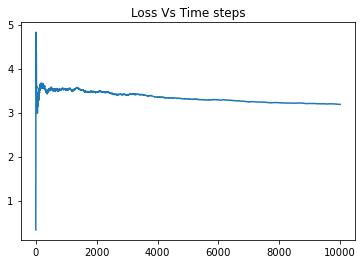

In [9]:
neural_net = train_model(train_ds, epochs=EPOCHS)

把結果畫出來

In [10]:
def plot_model_comparison_to_average(model, ds, model_name='neural network', K=10):
    '''拿多個task(sine wave)的average與模型預測值比較'''
    # calculate average prediction
    avg_pred = []
    for i, sinusoid_generator in enumerate(ds):
        x, y = sinusoid_generator.equally_spaced_samples()
        avg_pred.append(y)
    
    x, _ = SinusoidGenerator(K=K).equally_spaced_samples()    
    avg_plot, = plt.plot(x, np.mean(avg_pred, axis=0), '--')

    # calculate model prediction
    model_pred = model.forward(tf.convert_to_tensor(x))
    model_plot, = plt.plot(x, model_pred.numpy())
    
    # plot
    plt.legend([avg_plot, model_plot], ['Sine wave Average', f'{model_name} predictions'])
    plt.show()

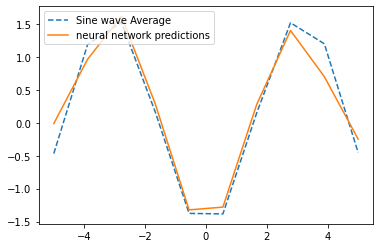

In [11]:
plot_model_comparison_to_average(neural_net, train_ds)

## Transfer Learning
試試看 transfer learning效果如何

In [12]:
def copy_model(model, x):
    '''把model 參數複製給另一個model'''
    copied_model = SineModel()
    # If we don't run this step the weights are not "initialized"
    # and the gradients will not be computed.
    copied_model.forward(tf.convert_to_tensor(x))
    copied_model.set_weights(model.get_weights())
    return copied_model
    
'''Meta testing: 評估已經train好的meta model'''
def eval_sine_test(model, optimizer, x, y, x_test, y_test, num_steps=10):
    fit_res = []
    tensor_x_test, tensor_y_test = np_to_tensor((x_test, y_test))
    
    # 紀錄第0個step(還沒開始adapt)的結果
    logits = model.forward(tensor_x_test)
    loss = loss_function(tensor_y_test, logits)
    fit_res.append((0, logits, loss))
    # Adaptation: 對target sinewave(task)做幾個step 的training  
    for step in range(1, np.max(num_steps) + 1):
        train_batch(x, y, model, optimizer)
        
        logits = model.forward(tensor_x_test)
        loss = loss_function(tensor_y_test, logits)
        # 紀錄第每個step的結果
        fit_res.append((step, logits, loss))
    return fit_res

def eval_sinewave_for_test(model, sinusoid_generator=None, num_steps=[0, 1, 5, 10], 
                           lr=0.01, plot=True):
    if sinusoid_generator is None:
        sinusoid_generator = SinusoidGenerator(K=10)
        
    '''target set sinwave中從x=-5~5固定間隔100個點當波形對照'''
    x_test, y_test = sinusoid_generator.equally_spaced_samples(100)
    
    '''target set sinwave中從x=-5~5亂選10個拿來train model'''
    x, y = sinusoid_generator.batch()
    
    '''把meta model保存起來，每train一個task就要還原一次'''
    copied_model = copy_model(model, x)
    
    # use SGD for this part of training as described in the paper
    optimizer = keras.optimizers.SGD(learning_rate=lr)
    
    '''Meta testing用的training, 要把中間loss都記下來'''
    fit_res = eval_sine_test(copied_model, optimizer, x, y, x_test, y_test, 
                             num_steps=max(num_steps))
    
    # plot
    train, = plt.plot(x, y, '^')
    ground_truth, = plt.plot(x_test, y_test)
    plots = [train, ground_truth]
    legend = ['Training Points', 'True Function']
    for n, res, loss in fit_res:
        if n in num_steps:
            cur, = plt.plot(x_test, res[:, 0], '--')
            plots.append(cur)
            legend.append(f'After {n} Steps')
    plt.legend(plots, legend)
    plt.ylim(-5, 5)
    plt.xlim(-6, 6)
    if plot:
        plt.show()
    
    return fit_res

用3種不同sinewave試試看transfer效果

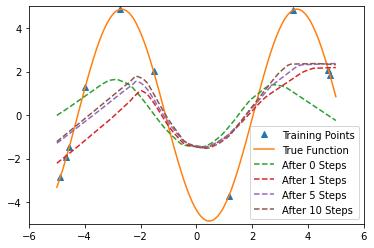

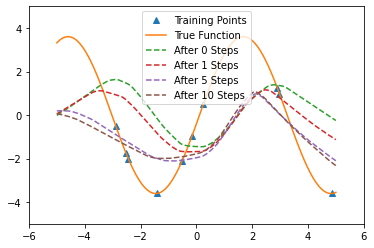

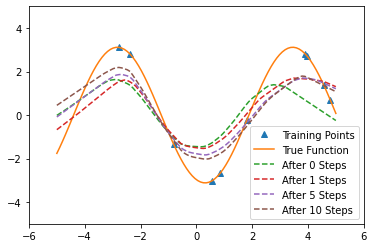

In [14]:
for index in np.random.randint(0, len(test_ds), size=3):
    eval_sinewave_for_test(neural_net, test_ds[index])

不同sinewave效果不一，不過大致上有adapt沒adapt差不多

### MAML

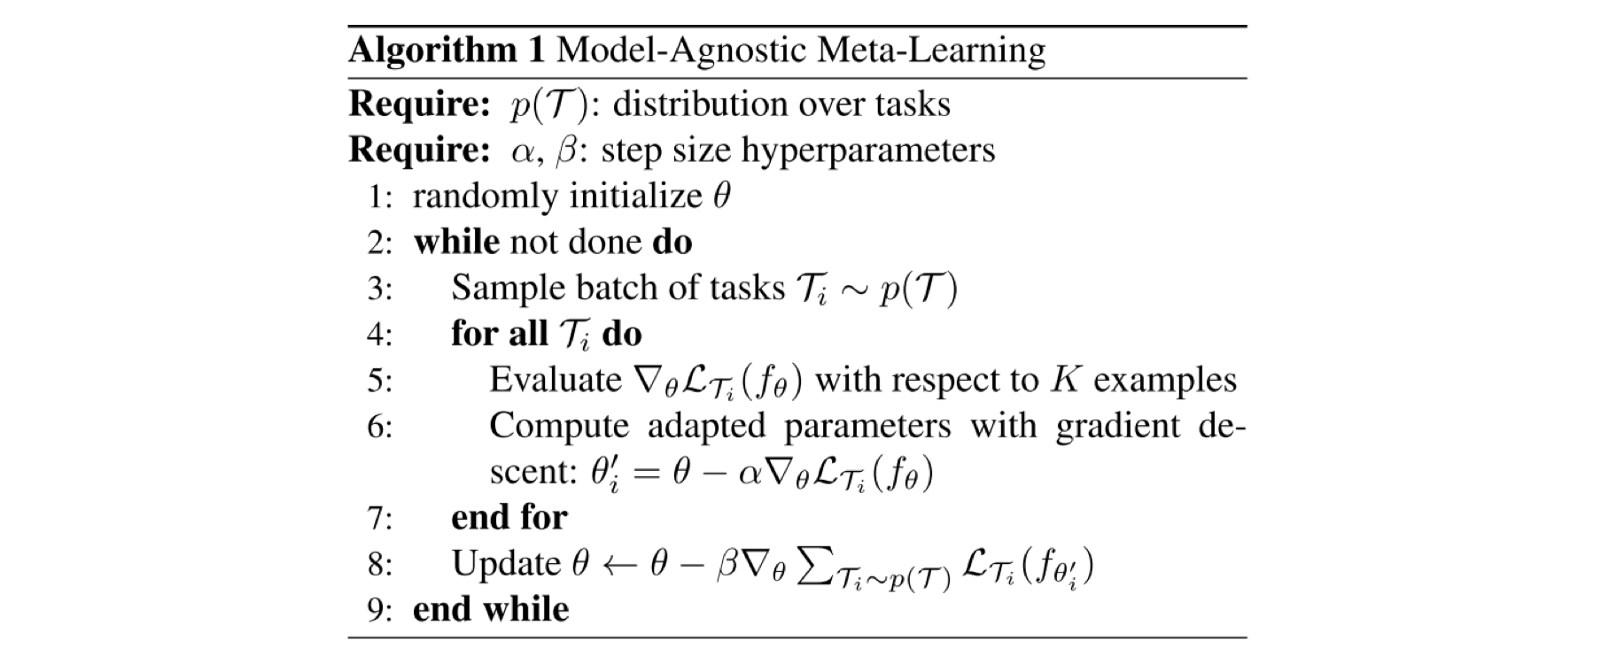

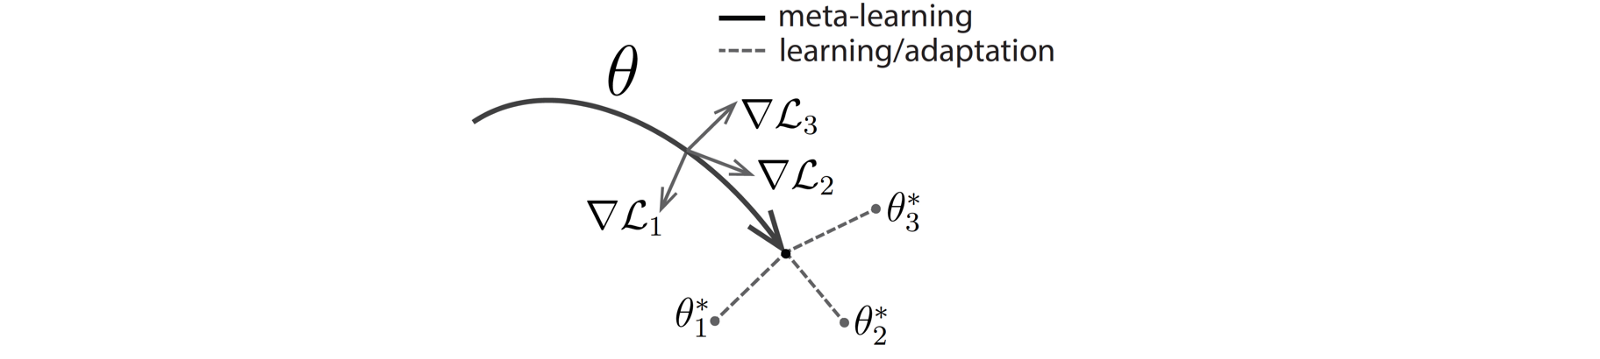

In [15]:
def train_maml(model, epochs, dataset, lr_inner=0.01, batch_size=1, log_steps=1000):

    optimizer = keras.optimizers.Adam()
    '''訓練指定的epoch量'''
    for _ in range(epochs):
        total_loss = 0
        losses = []
        start = time.time()
        '''sample幾個dataset出來'''
        for i, t in enumerate(random.sample(dataset, len(dataset))):
            x, y = np_to_tensor(t.batch())
            # 要先forward一次才能初始化參數
            model.forward(x) 
            '''Meta model(initial weight) 用的gradient tape: outer Loop'''
            with tf.GradientTape() as test_tape:
                '''每個Task用的gradient tape: inner loop'''
                with tf.GradientTape() as train_tape:
                    logits=model.forward(x)
                    train_loss=loss_function(y, logits)
                gradients = train_tape.gradient(train_loss, model.trainable_variables)# 算一下loss引發的gradient
                '''Adaptation: 對model進行更新'''
                k = 0
                model_copy = copy_model(model, x)# 保留元參數，使用一個copy model來對task進行SGD更新
                for j in range(len(model_copy.layers)):
                    model_copy.layers[j].kernel = tf.subtract(model.layers[j].kernel,
                                tf.multiply(lr_inner, gradients[k]))
                    model_copy.layers[j].bias = tf.subtract(model.layers[j].bias,
                                tf.multiply(lr_inner, gradients[k+1]))
                    k += 2
                '''更新完以後再跑一次model算meta update用的loss'''
                logits=model_copy.forward(x)
                test_loss=loss_function(y, logits)
            '''使用meta loss更新 meta model(initial weight)'''
            gradients = test_tape.gradient(test_loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
            
            # Logs
            total_loss += test_loss
            loss = total_loss / (i+1.0)
            losses.append(loss)
            
            if i % log_steps == 0 and i > 0:
                print('Step {}: loss = {}, Time to run {} steps = {}'.format(i, loss, log_steps, time.time() - start))
                start = time.time()
        plt.plot(losses)
        plt.show()

### Training MAML

會花點時間train 10000個task

Step 1000: loss = 2.6683402061462402, Time to run 1000 steps = 20.363855838775635
Step 2000: loss = 2.2103450298309326, Time to run 1000 steps = 21.114898681640625
Step 3000: loss = 1.8941209316253662, Time to run 1000 steps = 22.893470764160156
Step 4000: loss = 1.633998990058899, Time to run 1000 steps = 20.111706018447876
Step 5000: loss = 1.471594214439392, Time to run 1000 steps = 20.033372402191162
Step 6000: loss = 1.3425511121749878, Time to run 1000 steps = 20.03327751159668
Step 7000: loss = 1.2393255233764648, Time to run 1000 steps = 19.986303091049194
Step 8000: loss = 1.1556181907653809, Time to run 1000 steps = 19.97045874595642
Step 9000: loss = 1.0863821506500244, Time to run 1000 steps = 19.92350745201111


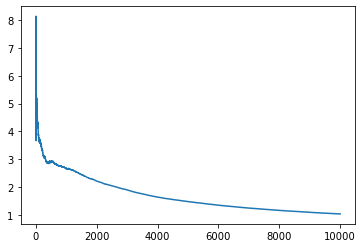

In [16]:
maml = SineModel()
train_maml(model=maml, epochs=EPOCHS, dataset=train_ds)

#### Use MAML model to fit new sine wave

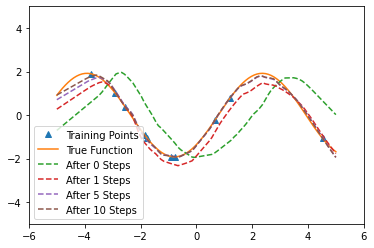

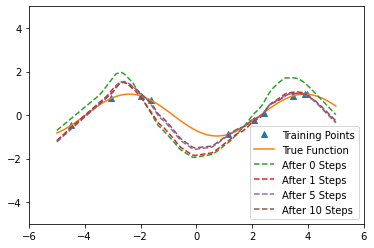

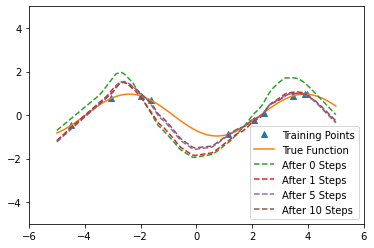

In [17]:
for index in np.random.randint(0, len(test_ds), size=3):
    eval_sinewave_for_test(maml, test_ds[index])

結果可以看出來，MAML還沒adapt過跟adapt過比起來差比較多，而且只要1個sample就可以很有效的增進prediction

# MAML vs Regular Transfer Learning
後面將兩種方法直接用圖來看差別

In [18]:
def compare_maml_and_neural_net(maml, neural_net, sinusoid_generator, num_steps=list(range(10)),
                                intermediate_plot=True, marker='x', linestyle='--'):
    '''比較MAML跟直接訓練的loss
    
    先畫出model 學習sine wave task的結果
    針對每個 `num_steps` 畫出對應的loss
    
    Args:
        maml: MAML方式預訓練好的模型
        neural_net: 傳統預訓練出來的模型
        num_steps: 最多幾個step
        intermediate_plot: 是否使用`eval_sinewave_for_test` function
        marker: Plot圖的標記
        linestyle: Plot圖用的線的種類
    '''
    if intermediate_plot:
        print('MAML')
    fit_maml = eval_sinewave_for_test(maml, sinusoid_generator, plot=intermediate_plot)
    if intermediate_plot:
        print('Neural Net')
    fit_neural_net = eval_sinewave_for_test(neural_net, sinusoid_generator, plot=intermediate_plot)
    
    fit_res = {'MAML': fit_maml, 'Neural Net': fit_neural_net}
    
    legend = []
    for name in fit_res:
        x = []
        y = []
        for n, _, loss in fit_res[name]:
            x.append(n)
            y.append(loss)
        plt.plot(x, y, marker=marker, linestyle=linestyle)
        plt.xticks(num_steps)
        plt.xlabel('adapt steps')
        plt.ylabel('loss')
        plt.title('MAML v.s Neural Net')
        legend.append(name)
    plt.legend(legend)
    plt.show()

#### sample 幾個 tasks(sine wave) 比較MAML 與 Neural Net在相同的task上adapt的結果與loss值

Task (Sine wave) No.0
MAML


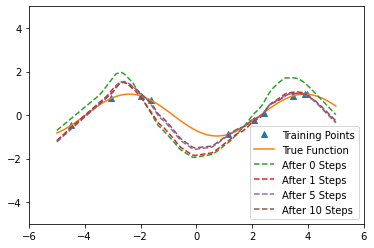

Neural Net


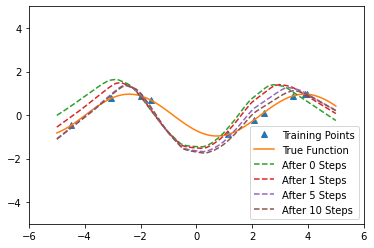

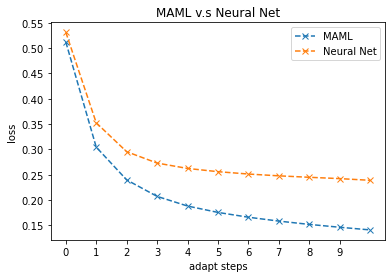

Task (Sine wave) No.1
MAML


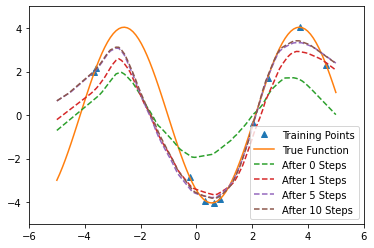

Neural Net


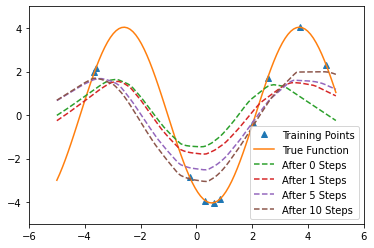

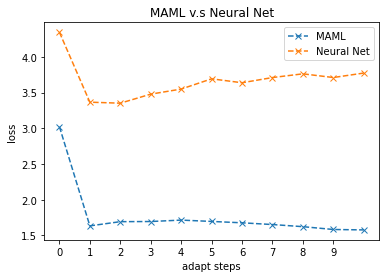

Task (Sine wave) No.2
MAML


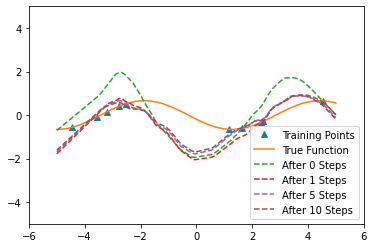

Neural Net


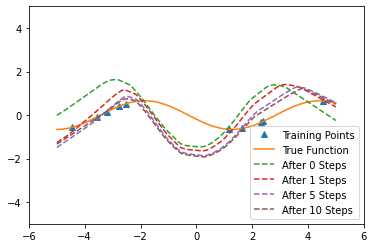

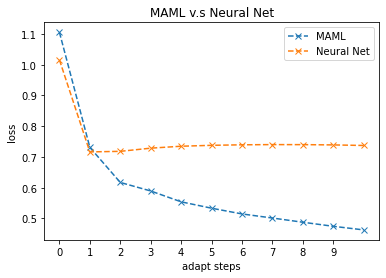

In [19]:
for i in range(3):
    index = np.random.choice(range(len(test_ds)))
    print(f'Task (Sine wave) No.{i}')
    compare_maml_and_neural_net(maml, neural_net, test_ds[index])

# Exercise
試著修改以下參數，觀察結果如何

1.   **TRAIN_SIZE** (# of sine wave tasks) 改成1000
2.   function **eval_sine_test** 的 **num_steps** (adaptation steps) 改成20
3.   修改**SineModel**
4.   **EPOCHS** 改成 2



# Reference
* [Github](https://github.com/mari-linhares/tensorflow-maml)